In [1]:
import os

import fire
import pandas as pd
import numpy as np
import plot_helpers.plot
import utils.rosbag
import importlib
import math
importlib.reload(plot_helpers.colors)

importlib.reload(plot_helpers.plot)
importlib.reload(utils.rosbag)
from utils.rosbag import create_frenet_converter, get_trackbounds_from_bag, get_detections_from_bag, get_states_from_bag, get_opponents_trajectories
from plot_helpers.colors import get_colors
from plot_helpers.plot import setup_grid, plot_points, finish_fig, add_legend_entry, plot_line, plot_arrow


In [4]:
END = 20 # 20 for traj
START = 0 # 0  for traj
NUM_OPPONENTS = 2
c = get_colors()
bag = "/home/moe/data/multi/video.bag"

In [5]:
def subsample_and_limit(df, every_n, limit, start=0):
    first_t = df["time"].iloc[0]
    last_t = first_t + limit
    index_of_last_t = df[df["time"] < last_t].index[-1]
    return df.iloc[::every_n, :index_of_last_t]


def setup_traj(df, fc):
    s = df["s"]
    d = df["d"]
    std = np.sqrt(df["var"])
    x_upper, y_upper = fc.get_cartesian(s, d + std)
    x_lower, y_lower = fc.get_cartesian(s, d - std)
    df["x_low"] = x_lower
    df["y_low"] = y_lower
    df["x_up"] = x_upper
    df["y_up"] = y_upper
    return df




In [7]:
fc  = create_frenet_converter(bag)
boundary_ext, boundary_int = get_trackbounds_from_bag(bag)
det = get_detections_from_bag(bag, fc)
det[1] = det[5]
trajectories = get_opponents_trajectories(bag)
trajectories.reverse()
trajectories[0] = setup_traj(trajectories[0], fc)
trajectories[1] = setup_traj(trajectories[1], fc)
opp_gt = []
opp_gt_frenet = []
# for i in range(NUM_OPPONENTS):
#     gt = get_states_from_bag(bag, f"/opp{i+1}/car_state/odom")
#     opp_gt.append(subsample_and_limit(gt, 24, END))
#     gt_frenet = get_states_from_bag(bag, f"/opp{i+1}/car_state/odom_frenet", frenet=True)
#     opp_gt_frenet.append(gt_frenet)

    

Trackbounds |████████████████████████████████████████| 1119/1119 [100%] in 0.0s (858320.38/s) 
Detections |████████████████████████████████████████| 3087/3087 [100%] in 0.2s (12834.06/s) 


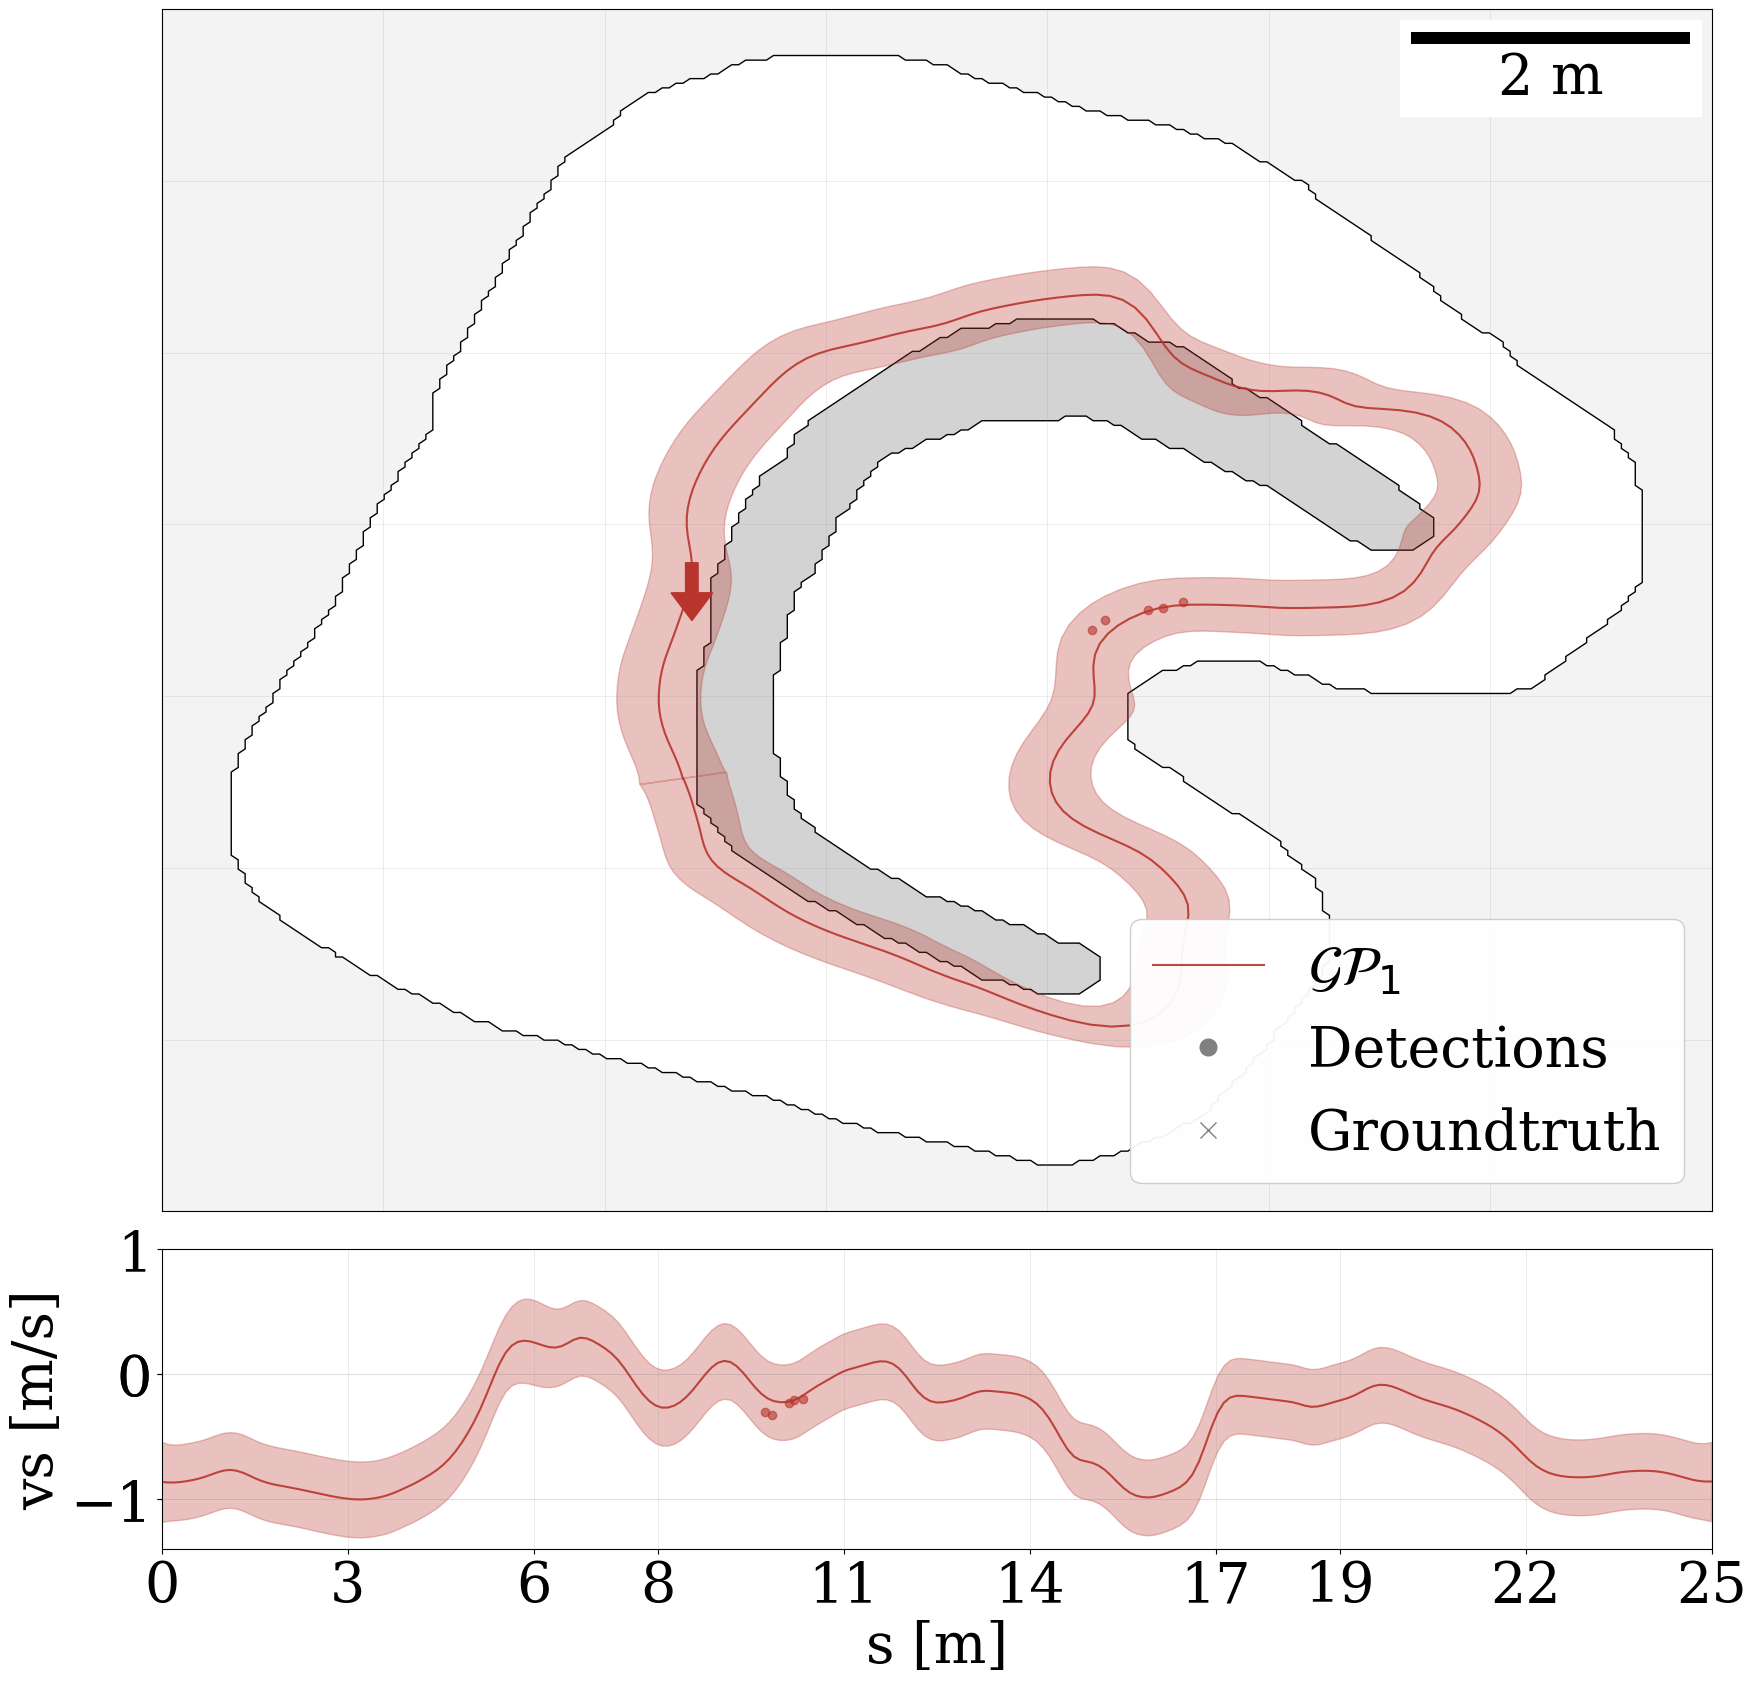

In [26]:
import plot_helpers.plot
import importlib

importlib.reload(plot_helpers.plot)
from plot_helpers.plot import plot_line
path = "/home/moe/ros_eval/plots/ot/gp_plot.pdf"
ARROW_INDECES = [220, 220]
config = [
    {
        "polygon": True,
        "legend": True,
        "height_ratio": 4,
        "scale": True,
    },
    {
        "x_label": "s [m]",
        "y_label": "vs [m/s]",
        "legend": False
    }
]



fig, axes = setup_grid(2, [boundary_ext.copy(), boundary_int.copy()], width=20, config=config, vert=True)

for i in range(NUM_OPPONENTS):
    if i > 0: continue
    det_idx = 5
    
    sub_d = det[det_idx].iloc[::6, :]
    axes[0] = plot_points(
        axes[0],
        sub_d,
        "y",
        'x',
        color=c[i],
    )
    
    # axes[0] = plot_points(
    #     axes[0],
    #     opp_gt[i],
    #     "position_y",
    #     'position_x',
    #     style="x",
    #     alpha=0.4,
    #     color=c[i],
    # )
    axes[0] = plot_line(
        axes[0],
        trajectories[i].copy(),
        c[i],
        fr'$\mathcal{{GP}}_{{{i+1}}}$',
        rotate=True,
        fill_around=True
    )

    arrow_x = trajectories[i]["y"].iloc[ARROW_INDECES[i]]
    arrow_y = trajectories[i]["x"].iloc[ARROW_INDECES[i]]
    dx = trajectories[i]["y"].iloc[ARROW_INDECES[i] + 1] - arrow_x
    dy = trajectories[i]["x"].iloc[ARROW_INDECES[i] + 1] - arrow_y
    yaw = math.atan2(dy, dx)

    axes[0] = plot_arrow(
        axes[0],
        arrow_x, arrow_y, yaw,
        color=c[i],
        size_multiplier=1.5)
    
    axes[1] = plot_points(
        axes[1],
        sub_d,
        "s",
        'd',
        color=c[i],
    )
    
    vs_data = pd.DataFrame()
    vs_data["x"] = trajectories[i]["s"]
    vs_data["y"] = trajectories[i]["d"]
    vs_data["var"] = trajectories[i]["var"]
    
    
    axes[1] = plot_line(
        axes[1],
        vs_data,
        c[i],
        fr'$\mathcal{{GP}}_{{{i+1}}}$',
        var=True,
    )



handles=[]
handles.append(add_legend_entry("Detections"))
handles.append(add_legend_entry("Groundtruth", "x"))
finish_fig(fig, path, handles, cols=1, config=config)
fig.show()
    